## Revisiting Regression

Predicting the future is hard. However, the theory that all statisticians get behind is that there are domains that can be mathematically represented with some degree of error.

Noise: general term for unwanted (and, in general, unknown) modifications

When we create statistical learning models, our aim is to find a signal (pattern) in the noise of data.

However, the model is less likely to find a pattern if our data is too noisy (i.e. too many outliers, non-normalized data, etc)

## P-Value of Coefficients 

We want to observe p-values after fitting a regression model.

In most statistical languages, OLS linear regression by default calculates:
* Coefficient 
* Hypothesis test score
* Corresponding p-value

Python unfortunately isn’t one of these statistical languages.

We therefore utilize an additional `f_regression` model to calculate p-values.

In [134]:
from sklearn.feature_selection import f_regression
import pandas as pd
import numpy as np
from scipy import stats

## EXTRACT
# load data
fbdf = pd.read_csv("../data/dataset_Facebook.csv")

## TRANSFORM
# drop unneeded columns & rename
fbdf_clean = fbdf.drop(labels=["Type", "Category", "Post Month", "Post Weekday", "Post Hour"], axis=1)
fbdf_clean.columns = ["tot_likes", "paid", "tot_reach", "tot_impressions", "engaged_users", "post_consumers", "post_consumptions", 
                      "tot_impressions_from_like", "tot_reach_from_like", "tot_engage_from_like", "comments", "likes", "shares", "interactions"]

# remove data past 3 z-scores for the target variable
fbdf_clean = fbdf_clean[(np.abs(stats.zscore(fbdf_clean["interactions"])) < 3)]

# log-normalize data
fbdf_clean_log = fbdf_clean
fbdf_clean_log.loc[:, "interactions"] = fbdf_clean_log["interactions"].apply(lambda x: np.log(x))

# remove infinites
fbdf_clean_log = fbdf_clean_log[np.isfinite(fbdf_clean_log["interactions"])]

# remove nulls
fbdf_clean_log.dropna(inplace=True)

## LOAD???
# maybe save data back here 

## CDA !
X_cols = list(fbdf_clean_log.columns)
X_cols.remove("interactions")

X = fbdf_clean_log[X_cols]
y = fbdf_clean_log["interactions"]

freg=f_regression(X,y)

for i, name in enumerate(X.columns):
    print(name, end=": ")
    print(round(freg[1][i], 10))

tot_likes: 0.2308899416
paid: 0.0055001587
tot_reach: 0.0
tot_impressions: 1.0464e-06
engaged_users: 0.0
post_consumers: 0.0
post_consumptions: 4.9916e-06
tot_impressions_from_like: 0.000272014
tot_reach_from_like: 0.0
tot_engage_from_like: 0.0
comments: 0.0
likes: 0.0
shares: 0.0


C:\Users\saidmf\AppData\Local\Temp\ipykernel_23180\4117073308.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbdf_clean_log.dropna(inplace=True)


For each coefficient that we predict, our OLS model does a hypothesis test:

* Essentially boils down to a one-sample t-test
  * What are the features of a one-sample t-test?
* Null Hypothesis: Coefficient is 0 (features is not a good predictor)
* Alt Hypothesis:  Coefficient is predicted value
* The calculation of this score isn’t as important as the utility, unless you have a Master’s in statistics and are hired to interpret statistical measures. 
  * (Coefficient slope - null hypothesis slope)/ standard error

* We look to remove features whose p-value is >= 0.05

In [20]:
import pandas as pd

estate = pd.read_csv("../data/realestate.csv")

estate.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [21]:
estate_clean = estate.drop(labels=["X1 transaction date", "X5 latitude", "X6 longitude"], axis=1)
estate_clean.columns = ["id", "age", "distance_to_mrt", "conv_stores", "price_unit_area"]
estate_clean.head()

,id,age,distance_to_mrt,conv_stores,price_unit_area
0,1,32.0,84.87882,10,37.9
1,2,19.5,306.59470,9,42.2
2,3,13.3,561.98450,5,47.3
3,4,13.3,561.98450,5,54.8
4,5,5.0,390.56840,5,43.1


## EDA

Exploratory Data Analysis : EXPLORE STRUCTURE & PATTERNS
* Visual
    * Histograms
    * Scatter-Plots
    * Confidence Intervals
* Quantitative
    * KS-Tests
    * Correlation
    * etc 

## Univariate EDA

Before we explore patterns, we should explore distributions & outliers by looking at individual features.

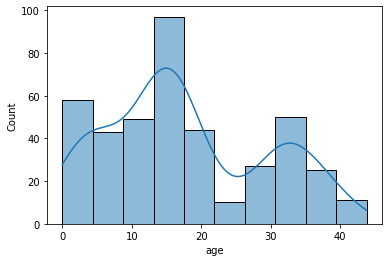

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(estate_clean["age"], kde=True)
plt.show()

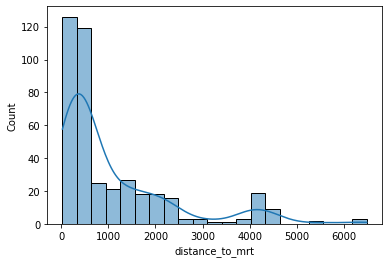

In [23]:
sns.histplot(estate_clean["distance_to_mrt"], kde=True)
plt.show()

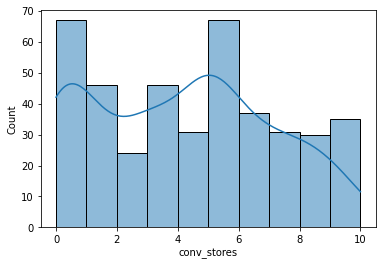

In [24]:
sns.histplot(estate_clean["conv_stores"], kde=True)
plt.show()

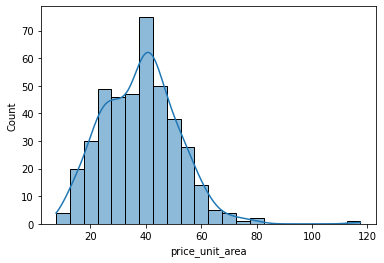

In [25]:
sns.histplot(estate_clean["price_unit_area"], kde=True)
plt.show()

<AxesSubplot:>

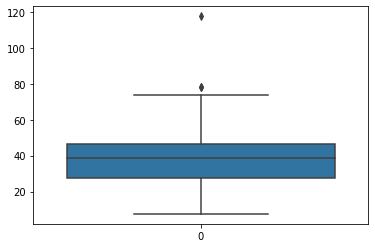

In [26]:
sns.boxplot(estate_clean["price_unit_area"])

In [27]:
import scipy.stats as stats

# mean = clean_df["salary_standardized"].mean(), std = clean_df["salary_standardized"].std()
stats.kstest(estate_clean["price_unit_area"], stats.norm.cdf, args=(estate_clean["price_unit_area"].mean(), estate_clean["price_unit_area"].std()))

KstestResult(statistic=0.03254610345274345, pvalue=0.7601105214572109)

## Outlier Nuance

While we've specified the validity of removing outliers in previous lectures, I want to rein in this piece of advice and 
limit it to the TARGET COLUMN.

Outliers in the predictors could truly represent interesting patterns, so therefore we will leave them in.
* unless we have good reason to remove them... (mistakes, anomolies, etc)

General rule of thumb: keep the outliers in your predictors, remove them in your target.

Furthermore, only begin the process of transforming your data after completing your EDA. 

<AxesSubplot:xlabel='price_unit_area', ylabel='Count'>

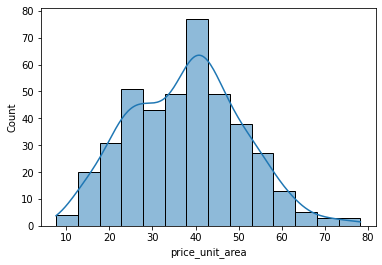

In [28]:
import scipy.stats as stats
import numpy as np

# remove data past 3 z-scores for the target variable

estate_clean = estate_clean[(np.abs(stats.zscore(estate_clean["price_unit_area"])) < 3)]
sns.histplot(estate_clean["price_unit_area"], kde=True)

<AxesSubplot:>

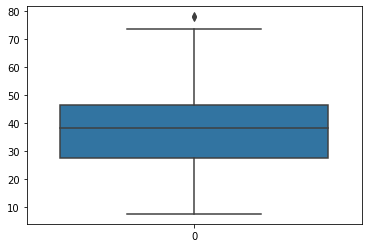

In [30]:
sns.boxplot(estate_clean["price_unit_area"])

In [29]:
import scipy.stats as stats

# mean = clean_df["salary_standardized"].mean(), std = clean_df["salary_standardized"].std()
stats.kstest(estate_clean["price_unit_area"], stats.norm.cdf, args=(estate_clean["price_unit_area"].mean(), estate_clean["price_unit_area"].std()))

KstestResult(statistic=0.038664959840662705, pvalue=0.5542427881478661)

## Bivariate EDA

Now that we have a good understanding of how individual features are distributed, let's explore patterns through bivariate EDA.

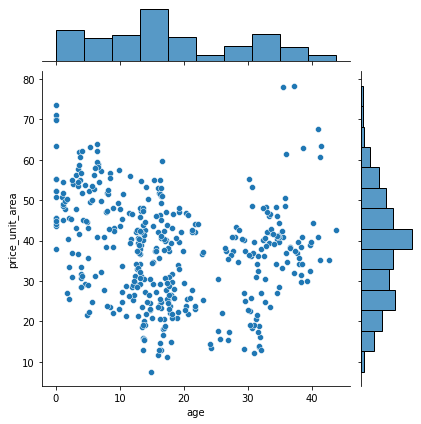

In [33]:
sns.jointplot(data = estate_clean, x = 'age', y = 'price_unit_area')
plt.show()

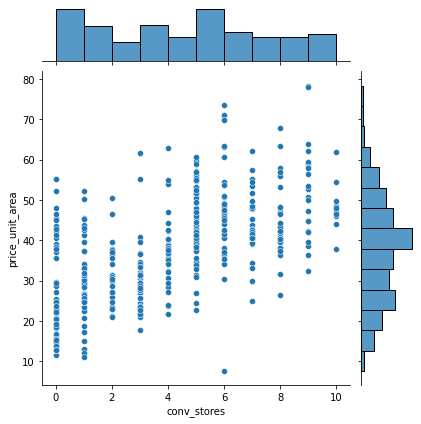

In [34]:
sns.jointplot(data = estate_clean, x = 'conv_stores', y = 'price_unit_area')
plt.show()

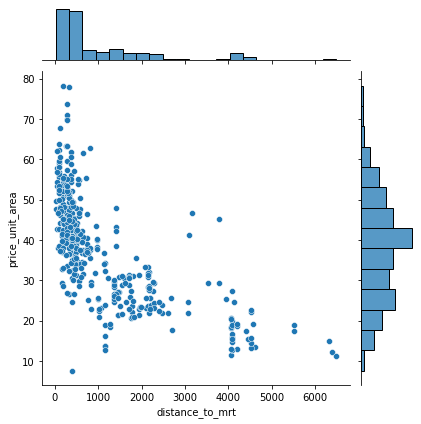

In [35]:
sns.jointplot(data = estate_clean, x = 'distance_to_mrt', y = 'price_unit_area')
plt.show()

## Polynomial Regression

We utilize polynomial regresion to model non-linear relationships between data.

Notice how the above scatter-plot follows a curve as opposed to a straight line.

We utilize polynomial regressors with different degrees to model different curves.

The general rule is that we include as many degrees as we there are "turns" in our dataset.

We do not have a discrete polynomial regressor that we can use. Instead we transform our features into polynomial features: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

This model expands our training data into multiple features where we apply some sort of exponent to a combination of variables.

First let's observe the regular X set.

In [101]:
from sklearn.model_selection import train_test_split

# some last minute cleaning..
estate_clean.dropna(inplace=True)

X = estate_clean[["distance_to_mrt"]]
y = estate_clean["price_unit_area"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X

,distance_to_mrt
0,84.87882
1,306.59470
2,561.98450
3,561.98450
4,390.56840
...,...
409,4082.01500
410,90.45606
411,390.96960
412,104.81010


In [102]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.3412621814036829

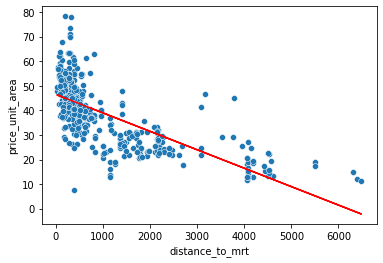

In [103]:
predictions = reg.predict(X_train)

sns.scatterplot(data = estate_clean, x = 'distance_to_mrt', y = 'price_unit_area')
plt.plot(X_train, predictions, c='r')
plt.show()

In [104]:
from sklearn.metrics import mean_squared_error

mse = []

y_pred = reg.predict(X_test)
m = mean_squared_error(y_test, y_pred)
mse.append(m)
m

101.93133252294207

In [105]:
from sklearn.metrics import mean_absolute_error

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred)

7.85259154561105

Next, let's see what kind of model we predict when considering the second degree of the `distance_to_mrt` feature.

In [151]:
from sklearn.preprocessing import PolynomialFeatures

X = estate_clean[["distance_to_mrt"]]
y = estate_clean["price_unit_area"]

poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X)

X_poly

array([[8.48788200e+01, 7.20441408e+03],
       [3.06594700e+02, 9.40003101e+04],
       [5.61984500e+02, 3.15826578e+05],
       [5.61984500e+02, 3.15826578e+05],
       [3.90568400e+02, 1.52543675e+05],
       [2.17503000e+03, 4.73075550e+06],
       [6.23473100e+02, 3.88718706e+05],
       [2.87602500e+02, 8.27151980e+04],
       [5.51203800e+03, 3.03825629e+07],
       [1.78318000e+03, 3.17973091e+06],
       [4.05213400e+02, 1.64197900e+05],
       [9.04560600e+01, 8.18229879e+03],
       [4.92231300e+02, 2.42291653e+05],
       [2.46964500e+03, 6.09914643e+06],
       [1.16483800e+03, 1.35684757e+06],
       [5.79208300e+02, 3.35482255e+05],
       [2.92997800e+02, 8.58477108e+04],
       [3.50851500e+02, 1.23096775e+05],
       [3.68136300e+02, 1.35524335e+05],
       [2.33828400e+01, 5.46757206e+02],
       [2.27587700e+03, 5.17961612e+06],
       [2.79172600e+02, 7.79373406e+04],
       [1.36013900e+03, 1.84997810e+06],
       [2.79172600e+02, 7.79373406e+04],
       [4.806977

In [136]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.20, random_state=42)

reg_poly = LinearRegression()
reg_poly.fit(X_train_p, y_train_p)
reg_poly.score(X_test_p, y_test_p)

0.4079148289264617

In [137]:
y_pred = reg_poly.predict(X_test_p)
m = mean_squared_error(y_test_p, y_pred)
mse.append(m)
m

91.61767967596282

In [138]:
y_pred = reg_poly.predict(X_test_p)
mean_absolute_error(y_test_p, y_pred)

6.972678378449715

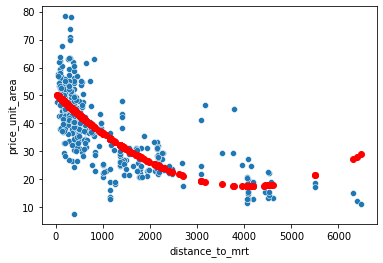

In [144]:
predictions = reg_poly.predict(X_poly)

sns.scatterplot(data = estate_clean, x = 'distance_to_mrt', y = 'price_unit_area')
plt.scatter(X["distance_to_mrt"], predictions, c='r')
plt.show()

Let's continue to increase the degree...

In [111]:
X = estate_clean[["distance_to_mrt"]]
y = estate_clean["price_unit_area"]

poly = PolynomialFeatures(3, include_bias=False)
X_poly = poly.fit_transform(X)

In [112]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.20, random_state=42)

reg_poly = LinearRegression()
reg_poly.fit(X_train_p, y_train_p)
reg_poly.score(X_test_p, y_test_p)

0.44669433171076767

In [113]:
y_pred = reg_poly.predict(X_test_p)
m = mean_squared_error(y_test_p, y_pred)
mse.append(m)
m

85.61704287966586

In [114]:
y_pred = reg_poly.predict(X_test_p)
mean_absolute_error(y_test_p, y_pred)

6.62602472295975

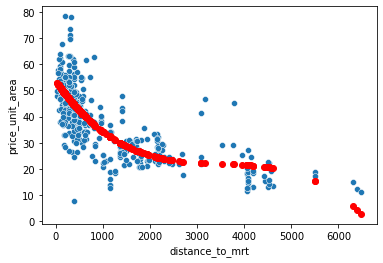

In [115]:
predictions = reg_poly.predict(X_poly)

sns.scatterplot(data = estate_clean, x = 'distance_to_mrt', y = 'price_unit_area')
plt.scatter(X["distance_to_mrt"], predictions, c='r')
plt.show()

Let's see what happens if we continue to increase this degree.

In [128]:
X = estate_clean[["distance_to_mrt"]]
y = estate_clean["price_unit_area"]


degrees = [1,2,3,4,5,6,7,8,9]

mse_test = []
mse_train = []
for d in degrees:
    poly = PolynomialFeatures(d, include_bias=False)
    X_poly = poly.fit_transform(X)

    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.20, random_state=42)

    reg_poly = LinearRegression()
    reg_poly.fit(X_train_p, y_train_p)

    y_pred_test = reg_poly.predict(X_test_p)
    m_test = mean_squared_error(y_test_p, y_pred_test)
    mse_test.append(m_test)

    y_pred_train = reg_poly.predict(X_train_p)
    m_train = mean_squared_error(y_train_p, y_pred_train)
    mse_train.append(m_train)

## Bias-Variance Tradeoff

When we start introducing more complexity to our models, we can run the risk of introducing high variance to our models.

Variance: Error from sensitivity to small fluctuations in the training set. We run the risk of modeling noise.

Bias: Error from assumptions in the learning algorithm. We run the risk of missing patterns.

Variance & bias are inversely correlated. 
* The more variance you have, the less bias.
* The more bias you have, the less variance.

We have to find the optimal tradeoff. 

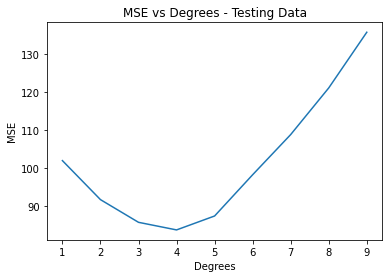

In [123]:
plt.plot(degrees, mse_test)
plt.title("MSE vs Degrees - Testing Data")
plt.xlabel("Degrees")
plt.ylabel("MSE")
plt.show()

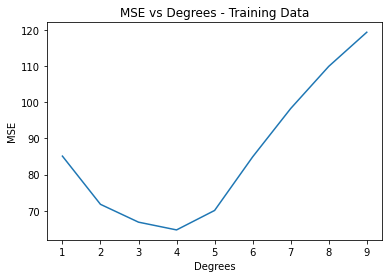

In [124]:
plt.plot(degrees, mse_train)
plt.title("MSE vs Degrees - Training Data")
plt.xlabel("Degrees")
plt.ylabel("MSE")
plt.show()

We do not see evidence of overfitting here as both training & testing data display the same error-rate. 

Overfitting: High variance in model leads to poor generalization of model in testing data & high error

Underfitting: High bias in model leads to poor generalization of model in training & testing data & high error

## Metrics

R2 sometimes increases as we include more unrelated variables (albeit marginally)

This could lead to us adding insignificant predictors to our model to achieve a higher accuracy.

This leads to poor model generalization!!!

R2 is a great metric to use after selecting your features (either automatically or manually), but we should opt for other metrics while training a model.

Instead we opt for different metrics of accuracy.

Residual: difference between real observation and predicted observation 

Mean-Squared-Error: average of squared difference of predicted data and target data 

Mean Absolute Error: average of all absolute difference between predicted data & target data

R2: aka coefficient of determination; the proportion of the variance for a dependent variable that's explained by an independent variabl

## MSE vs MAE

**Features of Mean-Squared-Error**
* Squares units of measurement. Ex: USD -> USD^2
* Heavily penalizes large error (residuals), ignores small error. Therefore MORE sensitive to outlier error
* Is used in L2-norm regularization (aka Euclidean Norm): *Ridge regression*

**Features of Mean-Absolute-Error**
* Preserve units of measurement. Ex: USD -> USD
* Weighs all errors the same
* Is used in L1-norm regularization (aka Manhattan Norm): *The LASSO*

## Normalization of Regression

When we have a large amount of predictors to choose from, or our model is experiencing high variance, we want to rely on penalty terms in our cost-function to reduce error.

**LASSO**
Purpose
* Prevent overfitting 
* Reduce effects of collinearity in your model
* Automatically select features by zeroing out features with large penalty

Use Case
* When fitting a multivariate model with many (>10?) features
* Best-Used when you have a small number of significant predictors.

**Ridge**
Purpose
* Prevent overfitting 
* Reduce effects of collinearity in your model
* Pushes coefficients close to 0, but does not feature select by setting to 0!

Use Case
* When fitting a multivariate model with many (>10?) features
* Best-Used when you have a large number of significant predictors that are close to the same magnitude

In [146]:
from sklearn.linear_model import Lasso

# get all features

X_cols = list(fbdf_clean_log.columns)
X_cols.remove("interactions")

X = fbdf_clean_log[X_cols]
y = fbdf_clean_log["interactions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# attempt LASSO
# we control how large the penalty is via `alpha`
# the larger the `alpha` is, the more features we zero out
# be aware that this might reduce model accuracy 
reglasso = Lasso(alpha=1.0)
reglasso.fit(X_train, y_train)

Lasso()

In [147]:
for i, name in enumerate(X.columns):
    print(name, end=": ")
    print(round(reglasso.coef_[i], 10))

tot_likes: 2.1887e-06
paid: 0.0
tot_reach: -1.9166e-06
tot_impressions: 1.7208e-06
engaged_users: 8.70456e-05
post_consumers: 0.0
post_consumptions: -5.845e-07
tot_impressions_from_like: -1.4578e-06
tot_reach_from_like: 7.9178e-06
tot_engage_from_like: 5.5111e-06
comments: 0.0
likes: 0.0031354066
shares: 0.0139059538


In [148]:
from sklearn.linear_model import Ridge

# get all features

X_cols = list(fbdf_clean_log.columns)
X_cols.remove("interactions")

X = fbdf_clean_log[X_cols]
y = fbdf_clean_log["interactions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# attempt LASSO
# we control how large the penalty is via `alpha`
# the larger the `alpha` is, the more features we zero out
# be aware that this might reduce model accuracy 
regridge = Ridge(alpha=1.0)
regridge.fit(X_train, y_train)

Ridge()

In [149]:
for i, name in enumerate(X.columns):
    print(name, end=": ")
    print(round(regridge.coef_[i], 10))

tot_likes: 2.4883e-06
paid: 0.1358576413
tot_reach: -2.9271e-06
tot_impressions: 1.814e-06
engaged_users: 0.001403668
post_consumers: -0.001336548
post_consumptions: 8.7295e-06
tot_impressions_from_like: -1.5142e-06
tot_reach_from_like: 1.12194e-05
tot_engage_from_like: 8.5856e-06
comments: 0.0038357851
likes: 0.0012935471
shares: 0.0208161195


## Confirmatory Data Analysis

As data analysts, we call this process "confirmatory data analysis" as opposed to "machine learning."

Machine learning engineers often deal with tuning highly complex statistical models.

We are just interested in generating understandable observations & confirming them.

## Try it Yourself!

Generate a polynomial regression to model the relationship between `age` and `price_unit_area`.

In [ ]:
import pandas as pd

estate = pd.read_csv("../data/realestate.csv")

estate_clean = estate.drop(labels=["X1 transaction date", "X5 latitude", "X6 longitude"], axis=1)
estate_clean.columns = ["id", "age", "distance_to_mrt", "conv_stores", "price_unit_area"]

estate_clean = estate_clean[(np.abs(stats.zscore(estate_clean["price_unit_area"])) < 3)]

# implement model here!

## Sprint 2

Your minimal viable model be an ETL pipeline that does the following simple tasks:
* Extracts data from your csv files
* Does light & minimal data transformations
    * Drop null rows, rename columns, etc
* Saves data back into csv files
* Generates a rough regression model with NO FEATURE SELECTION
  * What Andrew Ng calls a “Quick & Dirty Model”
  
Similar to the `predict.ipynb` file of yours End of Phase 2 Project.

Demo the results of this pipeline in a quick 5 minutes via guided presentation or slides.
At most, this should be two jupyter notebooks.

## Sprint 3

After completing your MVP ETL, complete an MVP EDA:
* Univariate:
    * Summary Statistics
    * Histograms
    * Box-Plots
    * Confidence Intervals 
    * KS-Test
* Bivariate:
    * Scatter-Plots
    * Correlation Map

Similar to the `eda.ipynb` file of yours End of Phase 2 Project.

Demo the results of this EDA in a quick 5 minutes via guided presentation or slides.
At most, this should be one jupyter notebook.